# Project 3: Web APIs & Classification

## Step 3: Further Data Preprocessing, Vectorization, Modelling

### Further data processing
Some further data processing is needed before fitting the inputs to vectorizers and models. Steps include:
- lemmatizing
- removing English stop words
- removing additional stop words manually

### Vectorization
- CounterVectorization in this current step

### Modelling
- Logistic Regression
- Multinomial Bayesian
Logistic Regression was able to provide a better accuracy, around 75% in validation sets as well as test sets

### Data Visualization
By studying the key words effective at differentiating "Democrats" vs "Republican", some insights were derived:

#### Democrats
- Democrats are more prone to mentioning "donald", "trump", "cruz", "republican", "right wing"
- Due to the recent news, "impeachment", "insurrection", "capitol", "resign" are the key identifiers in Democrats' posts
- Democrats also mention more "democracy" and "inauguration" in the posts, which seem to be what they are concerned

#### Conservatives
- "China", "communist", "leftist" are the top words to identify the posts of Conservatives
- "fraud", "evidence", "ballot" are related to recent news on election
- Conservatives tend to talk more "deal", "business", "tech", "big tech"

### Insights from key words
After refitting the model with the best parameters, the weightings of model coefficients were ranked and the more "influential" key words were examined. Comparing this list with the most common key words in the corpus, it was confirmed that the most popular words in the corpus may not be the most effectively in classification, ie the model was able to extract important key words from each class.

Those key words are good indicators of the current political landscape in US.

### Importing libaries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, auc

### Loading data from csv files

In [2]:
# load data from csv files saved in Steps 1 and 2
pd_dem = pd.read_csv("../data/democrats_comments.csv")
pd_con = pd.read_csv("../data/conservatives_comments.csv")

In [3]:
# add label: democrats as 1, con as -1
pd_dem["label"] = 1
pd_con["label"] = -1

In [4]:
data = pd.concat([pd_dem, pd_con])
data.reset_index(inplace=True)

In [5]:
data.shape

(1990, 7)

In [6]:
data.head()

,index,name,title,url_comments,comments,selftext,label
0,0,t3_kv4lr7,House Democrats launch second impeachment of T...,https://www.reddit.com/r/democrats/comments/kv...,Are they waiting for a response from Pence re ...,The House Article of Impeachment will be intro...,1
1,1,t3_kvg3xu,Do I have to,https://www.reddit.com/r/democrats/comments/kv...,Every time I look at Pence he reminds me of S...,NaN,1
2,2,t3_kv4oca,Camp Auschwitz guy identified,https://www.reddit.com/r/democrats/comments/kv...,Trump thought the riot looked low class I wo...,NaN,1
3,3,t3_kvekkt,No Crawling Back,https://www.reddit.com/r/democrats/comments/kv...,I just love how AOC takes no prisoners. She la...,NaN,1
4,4,t3_kvfqwa,Use the 14th Amendment to ban Trump,https://www.reddit.com/r/democrats/comments/kv...,Yep what s more Democrats got ahold of the S...,NaN,1


In [7]:
data["label"].value_counts(normalize=True)

 1    0.501005
-1    0.498995
Name: label, dtype: float64

### Base Case accuracy

Base Case Accuracy
The two classes are of roughly equal size, hence the base case accuracy is 50%. The goal of modelling is to build a model to classify at an accuracy substantially higher than 50%

### Function for cleaning up the text

In [8]:
def process_text(text):
    # Function to convert a raw text to a string of meaning words

    words = str(text)
    # Remove non-letters.
    try:
        words = re.sub("[^a-zA-Z]", " ", text)
    except:
        pass
    

    # Convert to lower case, split into individual words (list)
    words = words.lower().split()
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(i) for i in words]
    words = lemmatized_words
    
    #Convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    #Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [9]:
text = data.loc[0, "comments"]
text

'Are they waiting for a response from Pence re 25th before moving full speed ahead with impeachment  Yeah but when are they voting on it  I need to know when to turn on CSPAN  \n\n\nEdit  looks like Wednesday.. for like  no reason. This is irresponsible. Do it today  Your only job is voting on stuff.. and it s still business hours. It s what we pay you for. Sorry  I m kinda pissed. I read there s gonna be more violence  amp  the National Guard are being issued weapons. Good. Even if they don t remove him  which they probably won t be able to  this is the right thing to do.'

In [10]:
text = process_text(text)
text

'waiting response penny th moving full speed ahead impeachment yeah voting need know turn cspan edit look like wednesday like reason irresponsible today job voting stuff still business hour pay sorry kinda pissed read gonna violence amp national guard issued weapon good even remove probably able right thing'

#### Check the data types of fields

In [11]:
data.dtypes

index            int64
name            object
title           object
url_comments    object
comments        object
selftext        object
label            int64
dtype: object

#### Check null values

In [12]:
data.isnull().sum()

index              0
name               0
title              0
url_comments       0
comments         513
selftext        1911
label              0
dtype: int64

Some empty values in comments and selftext.

### Further processing text

In [13]:
# Processing text
data["title"] = data["title"].map(process_text)
data["comments"] = data["comments"].map(process_text)
data["selftext"] = data["selftext"].map(process_text)

In [14]:
data[["title", "comments", "selftext"]].head()

,title,comments,selftext
0,house democrat launch second impeachment trump...,waiting response penny th moving full speed ah...,house article impeachment introduced et today ...
1,,every time look penny reminds steve carell off...,nan
2,camp auschwitz guy identified,trump thought riot looked low class wonder shi...,nan
3,crawling back,love aoc take prisoner lay hold accountable wa...,nan
4,use th amendment ban trump,yep democrat got ahold senate house white hous...,nan


#### Processing Title + Comments + Selftext

In [15]:
### Combining three fields: Title + Comments + Selftext as Inputs (X)# Create data for model inputs - title and comments and selftext
# both X and y are to be lists
X = data["title"] + " " + data["comments"] + " " + data["selftext"]
y = data["label"]

#### Splitting training and test datasets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [17]:
X_train.shape

(1492,)

In [18]:
len(y_train)

1492

## CountVectorizer

In [19]:
# Using CountVectorizer
# set ngram to (1,2) instead of 1
cvec_naive = CountVectorizer(ngram_range=(1,2))

X_train_cvec_naive = cvec_naive.fit_transform(X_train).todense()
X_train_cvec_naive_df = pd.DataFrame(X_train_cvec_naive, columns = cvec_naive.get_feature_names())

In [20]:
X_train_cvec_naive_df.shape

(1492, 80055)

In [21]:
X_train_cvec_naive_df.head()

,aaaanndddd,aaaanndddd someone,aad,aad amp,aae,aae ddf,aaouww,aaouww cnfwaxy,ab,ab ab,...,zuck,zuck need,zuckerberg,zuckerberg biden,zuckerberg bloomberg,zuckerberg cancer,zuckerberg censor,zuckerberg corruption,zuckerberg eye,zuckerberg shut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Closer look at the most popular words in the training corpus

In [22]:
# find out how many times each word appear in the corpus by creating a 'Total' row at the end of the dataframe:
X_train_cvec_naive_df.loc['Total']= X_train_cvec_naive_df.sum(axis=0)
X_train_cvec_naive_df.loc['Total',:].sort_values(ascending=False)

nan                      1816
trump                    1075
wa                        880
people                    712
like                      492
                         ... 
picture placeholder         1
picture piece               1
picture normal              1
picture necessitating       1
aaaanndddd                  1
Name: Total, Length: 80055, dtype: int64

#### Create a DataFrame for the above Total Word Count, and then check, for each specified frequency (2, 10, 20, etc), what is the associated number of features (words) that appear in the corpus.


In [23]:
Xtrain_total_cvec_naive = pd.DataFrame(X_train_cvec_naive_df.loc['Total',:].sort_values(ascending=False))
Xtrain_total_cvec_naive.head()

,Total
nan,1816
trump,1075
wa,880
people,712
like,492


In [24]:
print(len(Xtrain_total_cvec_naive.loc[Xtrain_total_cvec_naive['Total'] <= 2]))
print(len(Xtrain_total_cvec_naive.loc[Xtrain_total_cvec_naive['Total'] <= 10]))
print(len(Xtrain_total_cvec_naive.loc[Xtrain_total_cvec_naive['Total'] <= 20]))
print(len(Xtrain_total_cvec_naive.loc[Xtrain_total_cvec_naive['Total'] <= 30]))
print(len(Xtrain_total_cvec_naive.loc[Xtrain_total_cvec_naive['Total'] <= 50]))
print(len(Xtrain_total_cvec_naive.loc[Xtrain_total_cvec_naive['Total'] <= 100]))
print(len(Xtrain_total_cvec_naive.loc[Xtrain_total_cvec_naive['Total'] <= 1000]))

73345
78467
79221
79517
79738
79934
80053


<BarContainer object of 18 artists>

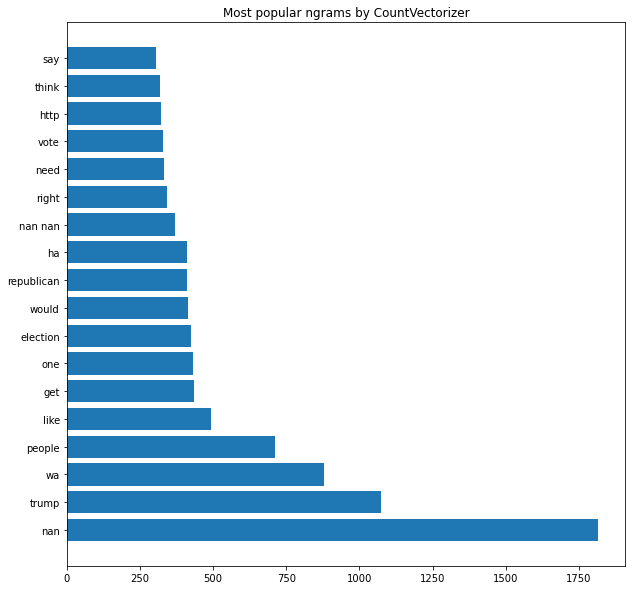

In [25]:
# plot histogram to observe the distribution
threshold = 300
figure = plt.figure(figsize=[10,10])
plt.title("Most popular ngrams by CountVectorizer")
plt.barh(Xtrain_total_cvec_naive[Xtrain_total_cvec_naive.Total > threshold].index.to_list(), Xtrain_total_cvec_naive[Xtrain_total_cvec_naive.Total > threshold]["Total"])

In [26]:
# Count of the tokens under the criteria
len(Xtrain_total_cvec_naive[Xtrain_total_cvec_naive.Total > threshold].index.to_list())

18

Additional stop words are needed to remove frequent words that are not so meaningful

### Additional stop words

In [27]:
additional_stop_words = ["nan", "thi", "wa", "hi", "would", "http"]

## Using Logistic Regression as a model

### Using Pipeline and GridSearchCV to run the model under a set of hyperparameters

In [28]:
pipe = Pipeline([
    ("cvec", CountVectorizer(stop_words=additional_stop_words, ngram_range=(1,2))),
    ("lr", LogisticRegression())
    ])

In [29]:
pipe_params = {
    'cvec__max_features': [300, 350, 400],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.05, .1, .15, .2],
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs = -1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(ngram_range=(1, 2),
                                                        stop_words=['nan',
                                                                    'thi', 'wa',
                                                                    'hi',
                                                                    'would',
                                                                    'http'])),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.05, 0.1, 0.15, 0.2],
                         'cvec__max_features': [300, 350, 400],
                         'cvec__min_df': [2, 3, 4]})

In [30]:
gs.cv_results_['mean_test_score']

array([0.6816682 , 0.68634823, 0.68030347, 0.67427218, 0.67762789,
       0.67293888, 0.68835043, 0.68634599, 0.68365693, 0.67560998,
       0.67628785, 0.67628561, 0.68231016, 0.68432134, 0.6829813 ,
       0.68031694, 0.68165473, 0.6843393 , 0.67496577, 0.6716168 ,
       0.67496577, 0.68700141, 0.6883437 , 0.68230792, 0.69103499,
       0.69171062, 0.69237279, 0.67160109, 0.67160109, 0.67294786,
       0.68968598, 0.68499473, 0.68901259, 0.6937016 , 0.69638616,
       0.68968598])

In [31]:
print(f'Validation best score: {gs.best_score_}')
print(f'Best params: {gs.best_params_}')
print(f'Training score: {gs.score(X_train, y_train)}')
print(f'Test score: {gs.score(X_test, y_test)}')

Validation best score: 0.6963861641713991
Best params: {'cvec__max_df': 0.2, 'cvec__max_features': 400, 'cvec__min_df': 3}
Training score: 0.8525469168900804
Test score: 0.7309236947791165


The validation scores are relatively stable, around 67-69%. There could be more room for a better model as some of the best params are at the extremes

### Fine-tuning hyperparameters

In [32]:
pipe_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [.15, .2, .25, .3]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs = -1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(ngram_range=(1, 2),
                                                        stop_words=['nan',
                                                                    'thi', 'wa',
                                                                    'hi',
                                                                    'would',
                                                                    'http'])),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.15, 0.2, 0.25, 0.3],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [4, 5, 6]})

In [33]:
gs.cv_results_['mean_test_score']

array([0.70509304, 0.70108415, 0.70308635, 0.72788265, 0.72788041,
       0.72453368, 0.73658504, 0.73525173, 0.72453817, 0.70576194,
       0.70241745, 0.70241745, 0.72922044, 0.73123162, 0.72653812,
       0.74261408, 0.7399385 , 0.73189827, 0.70912437, 0.70377096,
       0.70443312, 0.73189827, 0.73123162, 0.72788265, 0.74262082,
       0.74060964, 0.7298871 , 0.70912437, 0.70377096, 0.70443312,
       0.73189827, 0.73123162, 0.72788265, 0.74262082, 0.74060964,
       0.7298871 ])

In [34]:
print(f'Validation best score: {gs.best_score_}')
print(f'Best params: {gs.best_params_}')
print(f'Training score: {gs.score(X_train, y_train)}')
print(f'Test score: {gs.score(X_test, y_test)}')

Validation best score: 0.7426208165922201
Best params: {'cvec__max_df': 0.25, 'cvec__max_features': 3000, 'cvec__min_df': 4}
Training score: 0.9839142091152815
Test score: 0.751004016064257


There seems overfitting on the entire training set as the number of features increased significantly, but accuracy in both validation and test sets also improved to 75%. However it is noted that the variation of validation mean scores went up a bit.

### Plotting ROC curve

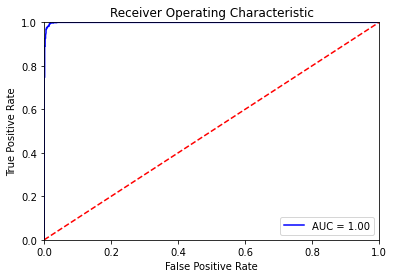

In [35]:
probs = gs.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_train, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Using Multinomial NB

In [36]:
pipe2 = Pipeline([
    ("cvec", CountVectorizer(stop_words=additional_stop_words, ngram_range=(1,2))),
    ("nb", MultinomialNB())
    ])

In [37]:
pipe_params = {
    'cvec__max_features': [300, 350, 400],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.05, .1, .15, .2],
}
gs2 = GridSearchCV(pipe2, param_grid=pipe_params, cv=5, n_jobs = -1)
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(ngram_range=(1, 2),
                                                        stop_words=['nan',
                                                                    'thi', 'wa',
                                                                    'hi',
                                                                    'would',
                                                                    'http'])),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.05, 0.1, 0.15, 0.2],
                         'cvec__max_features': [300, 350, 400],
                         'cvec__min_df': [2, 3, 4]})

In [38]:
gs2.cv_results_['mean_test_score']

array([0.68166147, 0.68233485, 0.67696572, 0.67763462, 0.67763238,
       0.67561895, 0.67629458, 0.6749523 , 0.67829678, 0.68094992,
       0.68162331, 0.68295886, 0.68363   , 0.68429889, 0.68564118,
       0.68967027, 0.68899688, 0.6916792 , 0.6943705 , 0.69369936,
       0.69235707, 0.68966802, 0.6910103 , 0.69167471, 0.69703935,
       0.69637045, 0.69502817, 0.6943705 , 0.69437274, 0.69370609,
       0.69101704, 0.68766807, 0.6910103 , 0.69235707, 0.69101479,
       0.68967475])

In [39]:
print(f'Validation best score: {gs2.best_score_}')
print(f'Best params: {gs2.best_params_}')
print(f'Training score: {gs2.score(X_train, y_train)}')
print(f'Test score: {gs2.score(X_test, y_test)}')

Validation best score: 0.6970393481627797
Best params: {'cvec__max_df': 0.15, 'cvec__max_features': 400, 'cvec__min_df': 2}
Training score: 0.7439678284182306
Test score: 0.7349397590361446


Hyperparameters are at extremes so will do further fine-tuning

### Adjusting hyper-parameters

In [40]:
pipe_params = {
    'cvec__max_features': [600, 800, 1000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.05, .1, .15, .2],
}
gs2 = GridSearchCV(pipe2, param_grid=pipe_params, cv=5, n_jobs = -1)
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(ngram_range=(1, 2),
                                                        stop_words=['nan',
                                                                    'thi', 'wa',
                                                                    'hi',
                                                                    'would',
                                                                    'http'])),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.05, 0.1, 0.15, 0.2],
                         'cvec__max_features': [600, 800, 1000],
                         'cvec__min_df': [2, 3, 4]})

In [41]:
gs2.cv_results_['mean_test_score']

array([0.68836165, 0.68500595, 0.68701937, 0.69773294, 0.69772845,
       0.69303944, 0.70912213, 0.71114004, 0.71181343, 0.69436376,
       0.69838836, 0.69570829, 0.70442414, 0.70509079, 0.70308411,
       0.71448228, 0.71314224, 0.70911764, 0.70643083, 0.70307737,
       0.70374851, 0.70711095, 0.70911989, 0.70509753, 0.71851586,
       0.7198559 , 0.7205203 , 0.70442414, 0.70174182, 0.70509753,
       0.70845099, 0.70711544, 0.70845548, 0.71852484, 0.71516015,
       0.71785145])

In [42]:
print(f'Validation best score: {gs2.best_score_}')
print(f'Best params: {gs2.best_params_}')
print(f'Training score: {gs2.score(X_train, y_train)}')
print(f'Test score: {gs2.score(X_test, y_test)}')

Validation best score: 0.7205203025745774
Best params: {'cvec__max_df': 0.15, 'cvec__max_features': 1000, 'cvec__min_df': 4}
Training score: 0.7908847184986595
Test score: 0.7329317269076305


Accuracy is lower than that of Logistic Regression. Similarly, overfitting the training set data became more apparent as the max_features increased

### Closer look at the most effective coefficients from the last model

In [43]:
# Using the params from gs.best_params_ of CounterVectorizer using Logistic Regression
# Best params: {'cvec__max_df': 0.25, 'cvec__max_features': 3000, 'cvec__min_df': 4}
cvec = CountVectorizer(ngram_range=(1, 2), stop_words=additional_stop_words, max_df=0.25, max_features=3000, min_df=4)
X_train_df  = pd.DataFrame(cvec.fit_transform(X_train).toarray(),
                   columns=cvec.get_feature_names())

In [44]:
lr = LogisticRegression()

In [45]:
lr.fit(X_train_df, y_train)

LogisticRegression()

In [46]:
lr.coef_

array([[-1.04089566e-01, -5.93477049e-02, -7.17151928e-02, ...,
         2.15869141e-04, -1.69729911e-01, -4.88417423e-01]])

In [47]:
len(list(cvec.get_feature_names()))

3000

In [48]:
df = pd.DataFrame(list(lr.coef_[0]), columns=["coef"])
df["feature"] = list(cvec.get_feature_names())

In [49]:
df.head()

,coef,feature
0,-0.104090,abandon
1,-0.059348,abandoned
2,-0.071715,abc
3,0.098046,abc news
4,-0.128567,ability


In [50]:
# Coefficients with the most +ve beta -> more "Democrats"
df.sort_values(by="coef", ascending=False).head(20)

,coef,feature
698,1.130655,democracy
395,1.119801,capitol
1047,1.004951,flag
2652,0.966960,today
2213,0.936728,rioter
2539,0.920401,support
2591,0.869763,ted
253,0.848813,best
626,0.823483,cruz
1563,0.796295,loser


In [51]:
# Coefficients with the most -ve beta -> more "Conservatives"
df.sort_values(by="coef", ascending=True).head(20)

,coef,feature
459,-1.647814,china
1484,-1.494267,leftist
934,-1.402385,evidence
662,-1.228332,deal
521,-1.220220,communist
1628,-1.149606,medium
206,-1.099364,ballot
106,-1.035640,analysis
692,-0.990319,deleted
1925,-0.989910,permit


### Comparing with the popular ngram in the entire dataset

In [52]:
# Entire dataset
data["text"] = data["title"] + " " + data["comments"] + " " + data["selftext"]
data.head()

,index,name,title,url_comments,comments,selftext,label,text
0,0,t3_kv4lr7,house democrat launch second impeachment trump...,https://www.reddit.com/r/democrats/comments/kv...,waiting response penny th moving full speed ah...,house article impeachment introduced et today ...,1,house democrat launch second impeachment trump...
1,1,t3_kvg3xu,,https://www.reddit.com/r/democrats/comments/kv...,every time look penny reminds steve carell off...,nan,1,every time look penny reminds steve carell of...
2,2,t3_kv4oca,camp auschwitz guy identified,https://www.reddit.com/r/democrats/comments/kv...,trump thought riot looked low class wonder shi...,nan,1,camp auschwitz guy identified trump thought ri...
3,3,t3_kvekkt,crawling back,https://www.reddit.com/r/democrats/comments/kv...,love aoc take prisoner lay hold accountable wa...,nan,1,crawling back love aoc take prisoner lay hold ...
4,4,t3_kvfqwa,use th amendment ban trump,https://www.reddit.com/r/democrats/comments/kv...,yep democrat got ahold senate house white hous...,nan,1,use th amendment ban trump yep democrat got ah...


### Common words in Democrats' posts

In [53]:
# Democrats only
text_demo = data["text"][data["label"]==1]
len(text_demo)

997

In [54]:
# Using CountVectorizer to get the most popular words in the entire data set of Democrats
# set ngram to (1,2)
cvec = CountVectorizer(ngram_range=(1,2))

In [55]:
cvec_demo = cvec.fit_transform(text_demo).todense()
cvec_demo_df = pd.DataFrame(cvec_demo, columns = cvec.get_feature_names())
cvec_demo_df.loc['Total']= cvec_demo_df.sum(axis=0)
cvec_demo_df.loc['Total',:].sort_values(ascending=False).head(20)


nan           1264
trump          751
wa             424
people         321
republican     316
nan nan        270
like           260
get            246
one            235
capitol        233
would          229
http           223
ha             208
right          207
need           207
georgia        186
vote           185
election       182
think          181
democrat       179
Name: Total, dtype: int64

Interestingly, some of the most common key words by count have a higher weightings in the Logistic Regression model, but not all of them. That shows that the model is able to identify those which will help differentiating Democrats' posts from Conservatives' posts eg impeachment.

### Common words in Conservatives' posts

In [56]:
# Conservatives only
text_con = data["text"][data["label"]==-1]
len(text_con)

993

In [57]:
text_con.head()

997     attention left right advocate violence anyone ...
998     exactly trump incite mob gt dodgy timeline gt ...
999     bully rule thee collusion dangerous monopoly b...
1000    facebook confirms data sharing agreement chine...
1001    northkoreadprk man never got recognition excep...
Name: text, dtype: object

In [58]:
# Using CountVectorizer to get the most popular words in the entire data set of Conservatives
# set ngram to (1,2)
cvec = CountVectorizer(ngram_range=(1,2))

In [59]:
cvec_con = cvec.fit_transform(text_con).todense()
cvec_con_df = pd.DataFrame(cvec_con, columns = cvec.get_feature_names())
cvec_con_df.loc['Total']= cvec_con_df.sum(axis=0)
cvec_con_df.loc['Total',:].sort_values(ascending=False).head(20)

nan         1161
wa           688
trump        647
people       552
like         373
election     346
one          331
ha           326
would        321
get          310
right        253
say          241
think        232
year         227
time         224
want         223
nan nan      223
even         221
need         218
vote         217
Name: Total, dtype: int64

Similar conclusion as compared to Democrats' common words. Words like "china" are not the most frequent, but are highly indicative of Conservatives